# COMS W4995 Deep Learning Project
Kai Zhou kz2329@columbia.edu Kathleen He kh3030@columbia.edu Yuechen Yang yy2608@columbia.edu

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Formatter
import datetime as dt
import pandas as pd

from importlib import reload
from time import time
import os.path

## Load Utilities

In [2]:
from utils.evaluator import Evaluator
from utils.formatter import DateFormatter

evaluator = Evaluator()

## Load Environment

In [3]:
from stable_baselines.common.vec_env import DummyVecEnv
from envs import equity_env

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
env = equity_env.EquityEnv(split_data=True)
env = DummyVecEnv([lambda: env])


-- Data Loaded --
-- Environment Created --


## Initialize Models 

In [5]:
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy
from stable_baselines.ppo2 import PPO2
# from stable_baselines import DDPG
from stable_baselines import A2C
from stable_baselines import ACKTR
# from stable_baselines import GAIL

from stable_baselines import bench, logger
from stable_baselines.results_plotter import load_results, ts2xy

### PPO2

In [6]:
model_ppo2 = PPO2(MlpLstmPolicy, env, n_steps=240, ent_coef=0.01, vf_coef=0.5,
             cliprange=0.2, learning_rate=1e-5, verbose=0, 
             nminibatches=1, policy_kwargs={"n_lstm":36, "layers":[36,36]})





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.




/usr/local/lib/python3.5/dist-packages/stable_baselines/common/policies.py:415: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





### DDPG

In [7]:
# model_ddpg = DDPG(MlpPolicy, env, verbose=1)


### A2C

In [8]:
model_a2c = A2C(MlpLstmPolicy, env, verbose=0,
                  n_steps=240, learning_rate=1e-5,
                  policy_kwargs={"n_lstm":36, "layers":[36,36]}               
               )

/usr/local/lib/python3.5/dist-packages/stable_baselines/common/policies.py:415: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")





Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### ACKTR

In [9]:
model_acktr = ACKTR(MlpLstmPolicy, env, verbose=0, 
                  n_steps=240, learning_rate=1e-5,
                  policy_kwargs={"n_lstm":36, "layers":[36,36]})                    


/usr/local/lib/python3.5/dist-packages/stable_baselines/common/policies.py:415: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")


### GAIL

In [10]:
# model_gail = GAIL(MlpLstmPolicy, env, verbose=0, 
#                   policy_kwargs={"n_lstm":36, "layers":[36,36]})


## Train Models

In [7]:
start = time()

total_timesteps = 120 * 20

model_ppo2.learn(total_timesteps=total_timesteps, tb_log_name="0bps_new_env")
# model_ddpg.learn(total_timesteps=total_timesteps, tb_log_name="0bps_new_env")
# model_a2c.learn(total_timesteps=total_timesteps, tb_log_name="0bps_new_env")
# model_acktr.learn(total_timesteps=total_timesteps, tb_log_name="0bps_new_env")
# model_gail.learn(total_timesteps=total_timesteps, tb_log_name="0bps_new_env")


end = time()
t = end - start
print("Takes %d s to run" % t)

Takes 16 s to run


## Evaluate Models

In [23]:
s = pd.read_csv("data/state.csv", index_col=0, parse_dates=True)
p = pd.read_csv("data/price.csv", index_col=0, parse_dates=True)

,open_gg,close_gg,high_gg,low_gg,volume_gg,open_am,close_am,high_am,low_am,volume_am,open_ms,close_ms,high_ms,low_ms,volume_ms
Dates,,,,,,,,,,,,,,,
2019-03-18 15:35:00,2.192433,-0.873027,-0.733255,-0.453382,-0.088028,1.625408,-1.304698,-0.819451,-1.119144,0.022606,2.565164,-0.360171,-0.851366,0.142880,-0.059540
2019-03-18 15:36:00,2.173399,0.407588,-0.197757,0.745964,-0.131665,1.590502,0.175067,-0.207567,0.807563,-0.036044,2.557945,0.313069,-0.142868,0.837142,-0.070801
2019-03-18 15:37:00,2.176211,-0.344333,-0.733255,0.266226,-0.200910,1.595985,-0.787672,-0.819451,-0.311907,0.093016,2.566367,-0.300061,-0.772644,0.374301,-0.049713
2019-03-18 15:38:00,2.167559,0.407588,-0.197757,0.745964,-0.135095,1.579936,0.371180,-0.074208,0.541022,-0.065157,2.560351,-0.119729,-0.615200,0.451441,-0.103310
2019-03-18 15:39:00,2.172317,0.278351,-0.323757,0.538077,-0.039365,1.588362,0.085924,-0.380150,0.777101,-0.228184,2.556741,-0.179839,-0.536478,0.374301,0.031969


In [20]:
dates = s.index

In [24]:
p.shape

(36007, 6)

In [25]:
reload(equity_env)

<module 'envs.equity_env' from '/home/jupyter/COMS-W4995-Deep-Learning-Project/envs/equity_env.py'>

In [26]:
dev_env = equity_env.EquityEnv(split_data=False, test_option="full")
dev_env = DummyVecEnv([lambda: dev_env])

-- Data Loaded --
-- Environment Created --


In [27]:
pnl_ppo2, date_ppo2, trans_cost_ppo2, actions_ppo2 = evaluator.evaluate(model_ppo2, dev_env)

In [57]:
dev_env = equity_env.EquityEnv(split_data=False, test_option="develop")
dev_env = DummyVecEnv([lambda: dev_env])

-- Data Loaded --
-- Environment Created --


In [58]:
start = time()

pnl_ppo2, date_ppo2, trans_cost_ppo2, actions_ppo2 = evaluator.evaluate(model_ppo2, dev_env)
# pnl_ddpg, date_ddpg, trans_cost_ddpg, actions_ddpg = evaluator.evaluate(model_ddpg, dev_env)
pnl_a2c, dates_a2c, trans_cost_a2c, actions_a2c = evaluator.evaluate(model_a2c, dev_env)
pnl_acktr, dates_acktr, trans_cost_acktr, actions_acktr = evaluator.evaluate(model_acktr, dev_env)
# pnl_gail, date_gail, trans_cost_gail, actions_gail = evaluator.evaluate(model_gail, dev_env)

end = time()
t = end - start
print("Takes %d s to run" % t)

Takes 199 s to run


In [59]:
print ("ppo2: ", evaluator.annual_sharpe(pnl_ppo2))
# print ("ddpg: ", evaluator.annual_sharpe(pnl_ddpg))
print ("a2c: ", evaluator.annual_sharpe(pnl_a2c))
print ("acktr: ", evaluator.annual_sharpe(pnl_acktr))
# print ("gail: ", evaluator.annual_sharpe(pnl_gail))


ppo2:  1.5053050281952023
a2c:  1.4154397034357662
acktr:  -11.88660847630602


In [60]:
print ("ppo2: ", evaluator.annual_return(pnl_ppo2))
# print ("ddpg: ", evaluator.annual_return(pnl_ddpg))
print ("a2c: ", evaluator.annual_return(pnl_a2c))
print ("acktr: ",evaluator.annual_return(pnl_acktr))
# print ("gail: ", evaluator.annual_return(pnl_gail))


ppo2:  0.03358896262896351
a2c:  0.024810989542830935
acktr:  -0.18695800328183207


In [61]:
print ("ppo2: ", evaluator.annual_volatility(pnl_ppo2))
# print ("ddpg: ", evaluator.annual_volatility(pnl_ddpg))
print ("a2c: ", evaluator.annual_volatility(pnl_a2c))
print ("acktr: ",evaluator.annual_volatility(pnl_acktr))
# print ("gail: ", evaluator.annual_volatility(pnl_gail))


ppo2:  0.0011287902736132117
a2c:  0.0008876527185431738
acktr:  0.000796325706566281


In [62]:
print ("ppo2: ", evaluator.maximum_drawdown(pnl_ppo2))
# print ("ddpg: ", evaluator.maximum_drawdown(pnl_ddpg))
print ("a2c: ", evaluator.maximum_drawdown(pnl_a2c))
print ("acktr: ",evaluator.maximum_drawdown(pnl_acktr))
# print ("gail: ", evaluator.maximum_drawdown(pnl_gail))


ppo2:  4.237707
a2c:  5.9428806
acktr:  61.044918


In [63]:
print ("ppo2: ", evaluator.annual_turnover(pnl_ppo2))
# print ("ddpg: ", evaluator.annual_turnover(pnl_ddpg))
print ("a2c: ", evaluator.annual_turnover(pnl_a2c))
print ("acktr: ",evaluator.annual_turnover(pnl_acktr))
# print ("gail: ", evaluator.annual_turnover(pnl_gail))

ppo2:  3540577.8703639396
a2c:  3306771.8715272956
acktr:  3986508.523926934


## Hyper-parameter tuning

In [20]:
import optunity

In [21]:
dev_env = equity_env.EquityEnv(split_data=False, test_option="develop")
dev_env = DummyVecEnv([lambda: dev_env])

-- Data Loaded --
-- Environment Created --


In [ ]:
# search = {"episode_len": {"120": {"ent_coef": [0.01, 0.1],
#                                   "vf_coef": [0.3, 0.8],
#                                   "cliprange": [0.1, 0.5],
#                                   "learning_rate": [1e-7, 1e-3],
#                                   "n_lstm": [8, 256]},
#                           "480": {"ent_coef": [0.01, 0.1],
#                                   "vf_coef": [0.3, 0.8],
#                                   "cliprange": [0.1, 0.5],
#                                   "learning_rate": [1e-7, 1e-3],
#                                   "n_lstm": [8, 256]}, 
#                           "1200": {"ent_coef": [0.01, 0.1],
#                                   "vf_coef": [0.3, 0.8],
#                                   "cliprange": [0.1, 0.5],
#                                   "learning_rate": [1e-7, 1e-3],
#                                   "n_lstm": [8, 256]}}}

In [ ]:
def performance(episode_len, ent_coef, vf_coef, cliprange, learning_rate, n_lstm):
    ep_len = int(episode_len)
    env = equity_env.EquityEnv(split_data=True, episode_length=ep_len)
    env = DummyVecEnv([lambda: env])
    model = PPO2(MlpLstmPolicy, env, n_steps=240, ent_coef=ent_coef, vf_coef=vf_coef,
                 cliprange=cliprange, learning_rate=learning_rate, verbose=0, 
                 nminibatches=1, policy_kwargs={"n_lstm":int(n_lstm), "layers":[36,36]})
    episode_num = int(200 / (ep_len / 120))
    model.learn(total_timesteps=ep_len*episode_num)        
    return evaluate_short(model, dev_env)

In [ ]:
t = time()
result = performance("1", 0.01, 0.5, 0.2, 1e-4, 36)
print("Takes %d s to run" % (time() - t))

In [ ]:
result

#### warning: the following two chunks of code can take a long time to run. 

In [ ]:
# optimal_configuration, info, _ = optunity.maximize_structured(performance, search_space=search, num_evals=50)

In [ ]:
model = PPO2(MlpLstmPolicy, env, n_steps=240, ent_coef=0.01, vf_coef=0.5,
             cliprange=0.2, learning_rate=1e-5, verbose=0, 
             nminibatches=1, policy_kwargs={"n_lstm":36, "layers":[36,36]})

pnl, dates, trans_cost, actions = evaluator.evaluate(model, dev_env)

In [ ]:
evaluator.annual_sharpe(pnl)

In [ ]:
evaluator.annual_return(pnl)

In [ ]:
evaluator.annual_volatility(pnl)

In [ ]:
evaluator.maximum_drawdown(pnl)

In [ ]:
evaluator.annual_turnover(actions)

## Construct Baseline Strategies

In [64]:
prices = pd.read_csv("data/price.csv", parse_dates=[0])
dates = prices.iloc[:,0].apply(lambda x: pd.to_datetime(x))
principal = 1000000

### 1. Momentum Strategy

In [65]:
# First, need to get return. need to define a look back period
def momentum_signal(price_data, look_back, normalize=True):
    price_data = prices.iloc[:, [2,4,6]].values
    delay_price = np.roll(price_data, look_back, axis=0)
    delay_price[:look_back] = np.nan
    mom_sig = (price_data - delay_price) / delay_price
    if normalize:
        mom_sig = mom_sig - mom_sig.mean(axis=1,keepdims=True)
        mom_sig = mom_sig / ((mom_sig > 0) * mom_sig).sum(axis=1, keepdims=True)
    return mom_sig

ret1 = momentum_signal(prices, 1, False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


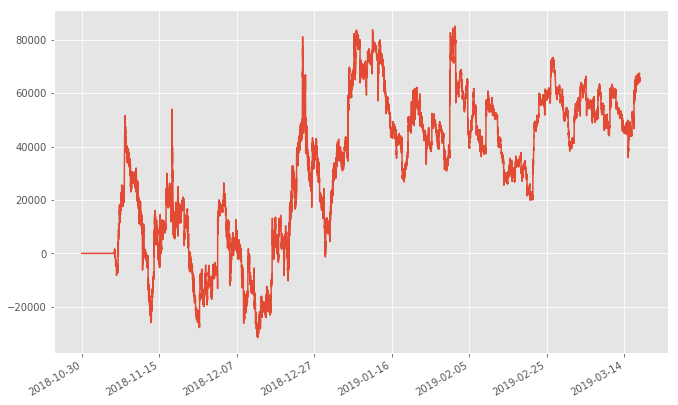

0.6869607785215986


In [66]:
mom = momentum_signal(prices, 2100)

pnl_mom = np.sum(mom * np.roll(ret1, -1, axis=0), axis=1) * principal
pnl_mom = np.nan_to_num(pnl_mom)

plt.style.use("ggplot")
formatter = DateFormatter(dates)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl_mom.shape[0]), np.cumsum(pnl_mom))
fig.autofmt_xdate()
plt.show()

print(evaluator.annual_sharpe(pnl_mom))

### 2. Buy-and-hold Strategy

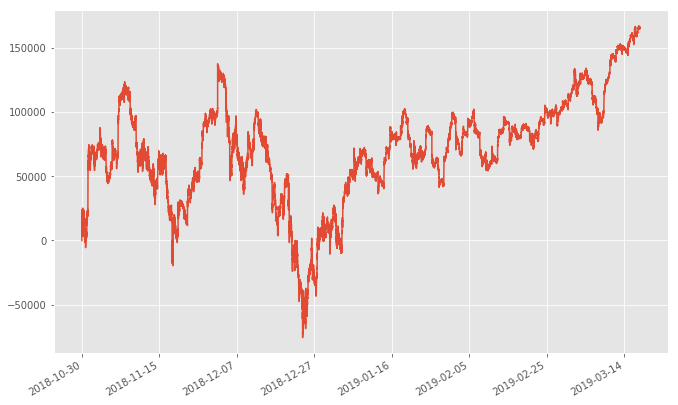

1.4030214749563588


In [67]:
mut = ret1+1
mut[0] = 1
pnl_hold = np.sum((np.cumprod(mut, axis=0)-1) / 3 * principal, axis=1)
pnl_hold = pnl_hold - np.roll(pnl_hold, 1)
pnl_hold[0] = 0
plt.style.use("ggplot")
formatter = DateFormatter(dates)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl_hold.shape[0]), np.cumsum(pnl_hold))
fig.autofmt_xdate()
plt.show()

print(evaluator.annual_sharpe(pnl_hold))

### 3. Compare RL with the baseline strategies

In [68]:
import pickle

In [69]:
with open("outputs/model_pnl_35000.dms", "rb") as f:
    pnl_ppo = pickle.load(f)

In [70]:
n = pnl_ppo.shape[0]
pnl_mom = pnl_mom[:n]
pnl_hold = pnl_hold[:n]

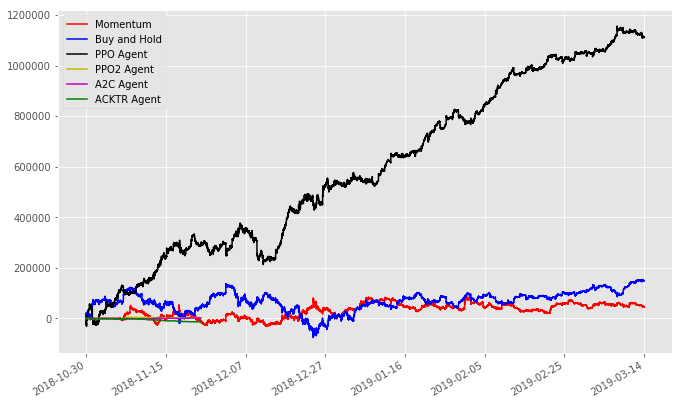

In [72]:
plt.style.use("ggplot")
formatter = DateFormatter(dates)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl_mom.shape[0]), np.cumsum(pnl_mom), c="r", label="Momentum")
ax.plot(np.arange(pnl_hold.shape[0]), np.cumsum(pnl_hold), c="b", label="Buy and Hold")
ax.plot(np.arange(pnl_ppo.shape[0]), np.cumsum(pnl_ppo), c="k", label="PPO Agent")
ax.plot(np.arange(pnl_ppo2.shape[0]), np.cumsum(pnl_ppo2), c="y", label="PPO2 Agent")
ax.plot(np.arange(pnl_a2c.shape[0]), np.cumsum(pnl_a2c), c="m", label="A2C Agent")
ax.plot(np.arange(pnl_acktr.shape[0]), np.cumsum(pnl_acktr), c="g", label="ACKTR Agent")

fig.autofmt_xdate()
plt.legend()
plt.show()

In [73]:
print ("buy and hold: ", evaluator.annual_sharpe(pnl_hold))
print ("Momentum: ", evaluator.annual_sharpe(pnl_mom))
print ("ppo pretrained: ", evaluator.annual_sharpe(pnl_ppo))

print ("ppo2: ", evaluator.annual_sharpe(pnl_ppo2))
# print ("ddpg: ", evaluator.annual_sharpe(pnl_ddpg))
print ("a2c: ", evaluator.annual_sharpe(pnl_a2c))
print ("acktr: ", evaluator.annual_sharpe(pnl_acktr))
# print ("gail: ", evaluator.annual_sharpe(pnl_gail))

buy and hold:  1.290701596957831
Momentum:  0.5092986197693166
ppo pretrained:  7.738935430798078
ppo2:  1.5053050281952023
a2c:  1.4154397034357662
acktr:  -11.88660847630602


In [74]:
print ("buy and hold: ", evaluator.annual_return(pnl_hold))
print ("Momentum: ", evaluator.annual_return(pnl_mom))
print ("ppo pretrained: ", evaluator.annual_return(pnl_ppo))

print ("ppo2: ", evaluator.annual_return(pnl_ppo2))
# print ("ddpg: ", evaluator.annual_return(pnl_ddpg))
print ("a2c: ", evaluator.annual_return(pnl_a2c))
print ("acktr: ",evaluator.annual_return(pnl_acktr))
# print ("gail: ", evaluator.annual_return(pnl_gail))

buy and hold:  0.4212974266840264
Momentum:  0.13128965114428454
ppo pretrained:  3.1184817582615683
ppo2:  0.03358896262896351
a2c:  0.024810989542830935
acktr:  -0.18695800328183207


In [75]:
print ("buy and hold: ", evaluator.annual_volatility(pnl_hold))
print ("Momentum: ", evaluator.annual_volatility(pnl_mom))
print ("ppo pretrained: ", evaluator.annual_return(pnl_ppo))

print ("ppo2: ", evaluator.annual_volatility(pnl_ppo2))
# print ("ddpg: ", evaluator.annual_volatility(pnl_ddpg))
print ("a2c: ", evaluator.annual_volatility(pnl_a2c))
print ("acktr: ",evaluator.annual_volatility(pnl_acktr))
# print ("gail: ", evaluator.annual_volatility(pnl_gail))

buy and hold:  0.016526553204027204
Momentum:  0.013035228758318574
ppo pretrained:  3.1184817582615683
ppo2:  0.0011287902736132117
a2c:  0.0008876527185431738
acktr:  0.000796325706566281


In [76]:
print ("buy and hold: ", evaluator.annual_turnover(pnl_hold))
print ("Momentum: ", evaluator.annual_turnover(pnl_mom))
print ("ppo pretrained: ", evaluator.annual_turnover(pnl_ppo))

print ("ppo2: ", evaluator.annual_turnover(pnl_ppo2))
# print ("ddpg: ", evaluator.annual_turnover(pnl_ddpg))
print ("a2c: ", evaluator.annual_turnover(pnl_a2c))
print ("acktr: ",evaluator.annual_turnover(pnl_acktr))
# print ("gail: ", evaluator.annual_turnover(pnl_gail))

buy and hold:  86527701.71825339
Momentum:  71896563.41905293
ppo pretrained:  109629239.616
ppo2:  3540577.8703639396
a2c:  3306771.8715272956
acktr:  3986508.523926934


In [77]:
print ("buy and hold: ", evaluator.maximum_drawdown(pnl_hold))
print ("Momentum: ", evaluator.maximum_drawdown(pnl_mom))
print ("ppo pretrained: ", evaluator.maximum_drawdown(pnl_ppo))


print ("ppo2: ", evaluator.maximum_drawdown(pnl_ppo2))
# print ("ddpg: ", evaluator.maximum_drawdown(pnl_ddpg))
print ("a2c: ", evaluator.maximum_drawdown(pnl_a2c))
print ("acktr: ",evaluator.maximum_drawdown(pnl_acktr))
# print ("gail: ", evaluator.maximum_drawdown(pnl_gail))

buy and hold:  1.5495394926428547
Momentum:  1.5841917099618854
ppo pretrained:  0.43500876
ppo2:  4.237707
a2c:  5.9428806
acktr:  61.044918
